# WFM stitching of 2D ROOT and McStas data

In [1]:
import os
import uproot
import matplotlib.pyplot as plt
import numpy as np
import wfmess

%matplotlib notebook

# choice of colormap for 2D plots
colormap = plt.cm.get_cmap('gist_earth')

## McStas

In [2]:
# McStas 2D file
mcstas_2dfile = "monitor_tx_DENEX.dat"

# path to load McStas simulation data 
path_to_model = '/Users/celinedurniak/V20DiffractionData'

assert os.path.isdir(path_to_model), 'The chosen path does not exist.'

# Folder containing output of McStas simulation
result_folder = 'V20_config6'

# access data stored after McStas simulations
folder_with_mcstas_data = os.path.join(path_to_model, result_folder)

assert os.path.isdir(folder_with_mcstas_data), \
'The folder which should contain outputs of McStas simulation does not exist.'

path_to_mcstas2D_file = os.path.join(path_to_model, result_folder, mcstas_2dfile)

assert os.path.isfile(path_to_mcstas2D_file), \
'There is an issue with the chosen McStas 2D datafile'

In [3]:
# Extract shape of output data
# these values will be used to determine how many lines to read one array

with open(path_to_mcstas2D_file, 'r') as file:
    for line in file:
        if "array_2d" in line:
            type_array = line.rstrip()
            start = type_array.find('(') + 1
            end = type_array.find(')', start)
            nx_value, ny_value = map(int, type_array[start:end].split(','))
        if "xylimits" in line:
            xylims = np.array(line.split(':')[1].split()).astype(np.float)

print(f'Limits of x- and y-axis: {xylims}\nNumber of points: nx={nx_value}, ny={ny_value}')

Limits of x- and y-axis: [ 0.005  0.075 -0.14   0.14 ]
Number of points: nx=560, ny=560


In [4]:
data2d = np.genfromtxt(path_to_mcstas2D_file, max_rows=ny_value)

#flip data along y axis 
data2d_mcstas = np.flip(data2d, 0)

# define x, y axes (bin-centered)
dx = (xylims[1] - xylims[0]) / float(nx_value)
dy = (xylims[3] - xylims[2]) / float(ny_value)
x = np.linspace(xylims[0] + 0.5*dx, xylims[1] - 0.5*dx, nx_value) * 1.0e6
y = np.linspace(xylims[2] + 0.5*dx, xylims[3] - 0.5*dy, nx_value)

<IPython.core.display.Javascript object>


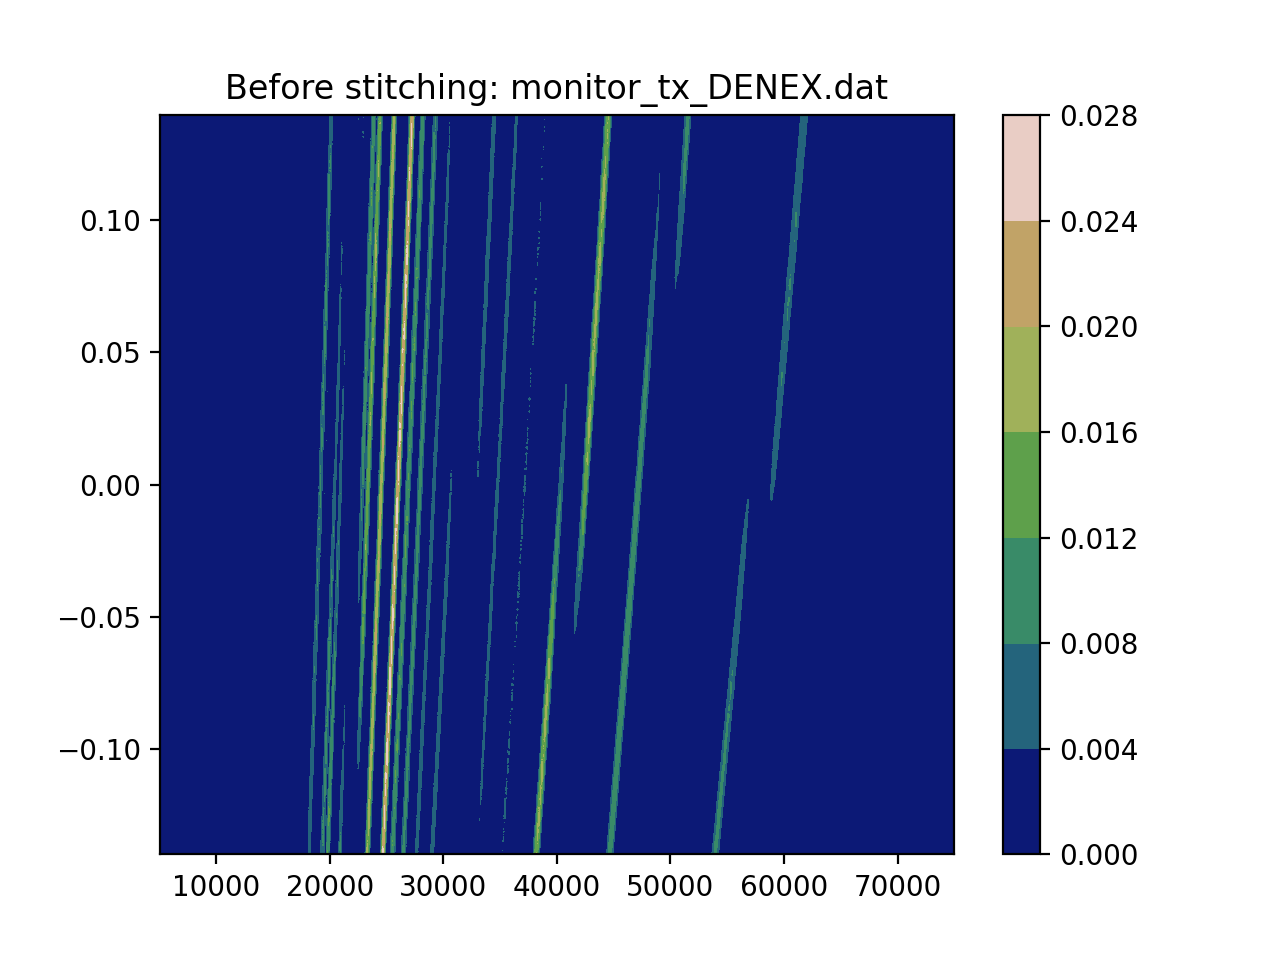

In [5]:
fig1, ax1 = plt.subplots()
cont1 = ax1.contourf(x, y, data2d_mcstas, cmap=colormap)    
ax1.set_title(f"Before stitching: {mcstas_2dfile}")
cbar1 = fig1.colorbar(cont1)

<IPython.core.display.Javascript object>


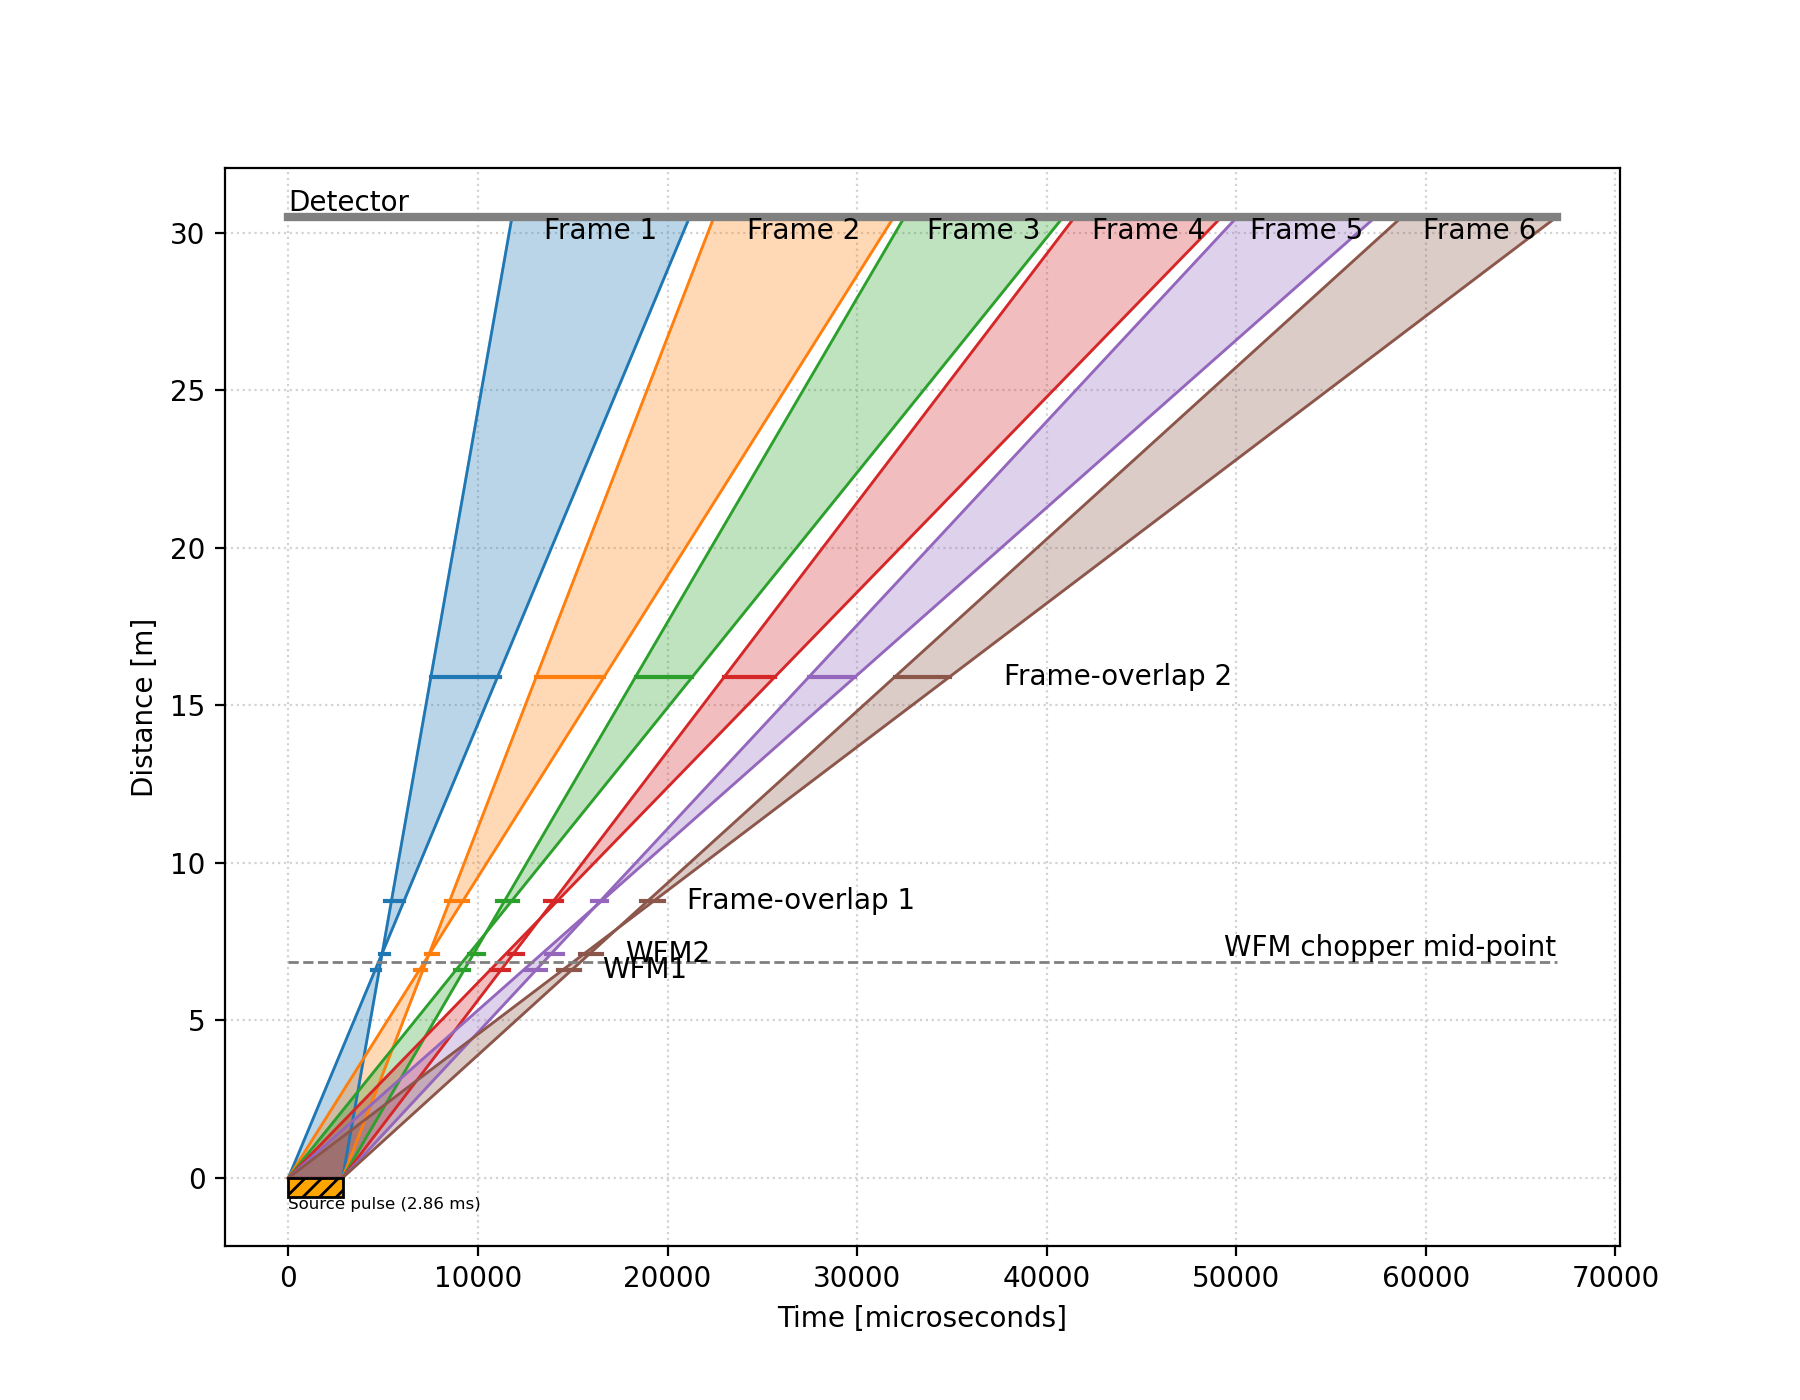

In [6]:
# Get the V20 instrument chopper setup
v20setup = wfmess.v20.setup()

# Apply random global phase shift
global_phase_offset = np.deg2rad(-34.5)
for key in v20setup["choppers"].keys():
    v20setup["choppers"][key].phase += global_phase_offset
    
# Change distance of detector
v20setup["info"]["detector_position"] = 30.5

# Get WFM frame parameters and generate TOF diagram
frame_params = wfmess.get_frame_parameters(instrument=v20setup, plot=True)

<IPython.core.display.Javascript object>


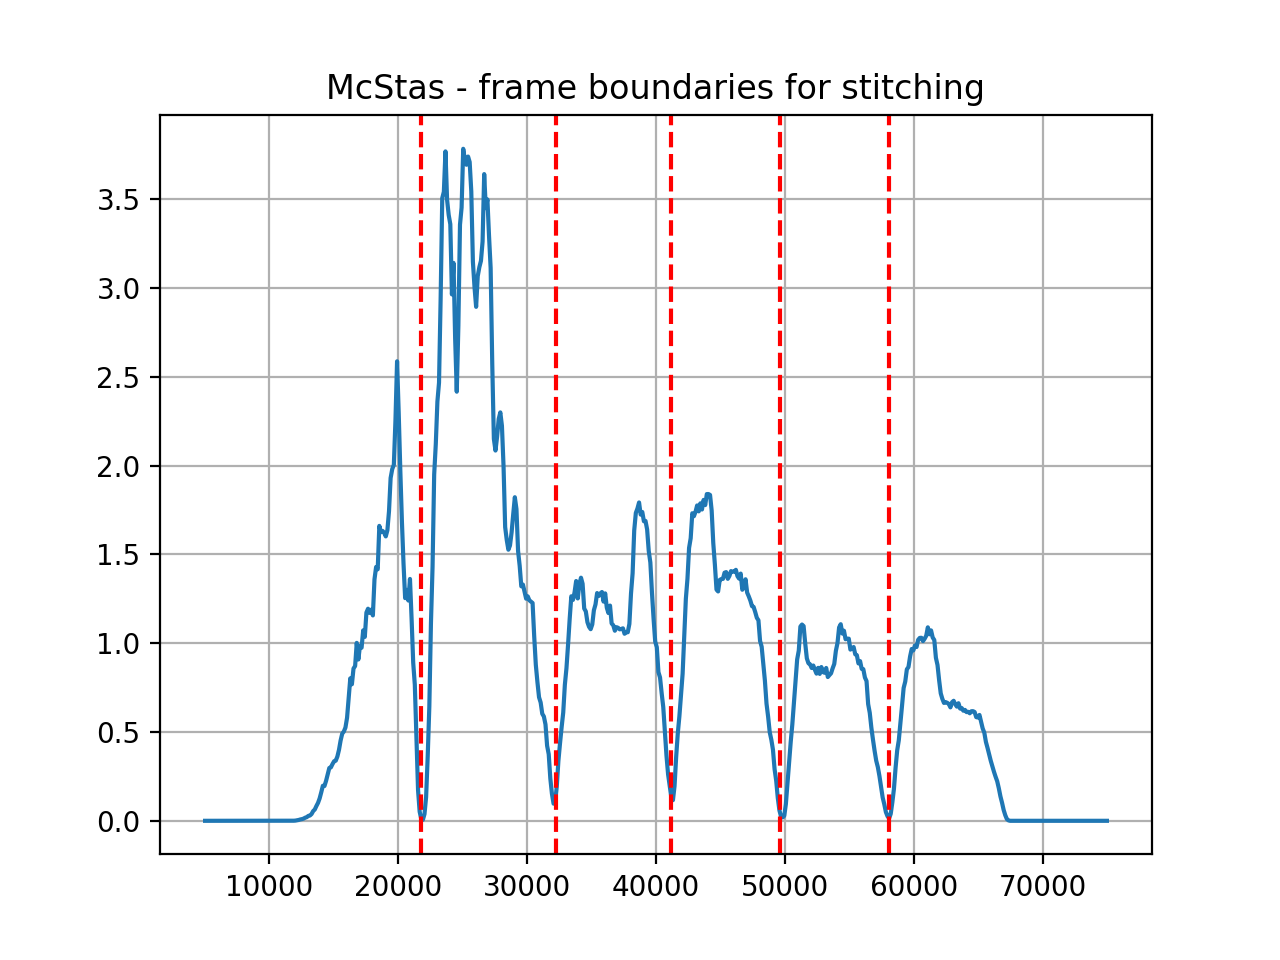

In [7]:
# Plot frame locations onto raw data
fig2, ax2 = plt.subplots()
ax2.plot(x, np.sum(data2d_mcstas, axis=0))
ax2.set_title('McStas - frame boundaries for stitching')

for gap in frame_params["gaps"]:
    ax2.axvline(x=gap, linestyle='--', color='r')
    
ax2.grid();

In [8]:
# Stitch the 2d histogram
mcstas_stitched = wfmess.stitch(x=x, y=data2d_mcstas, frame_params=frame_params)

<IPython.core.display.Javascript object>


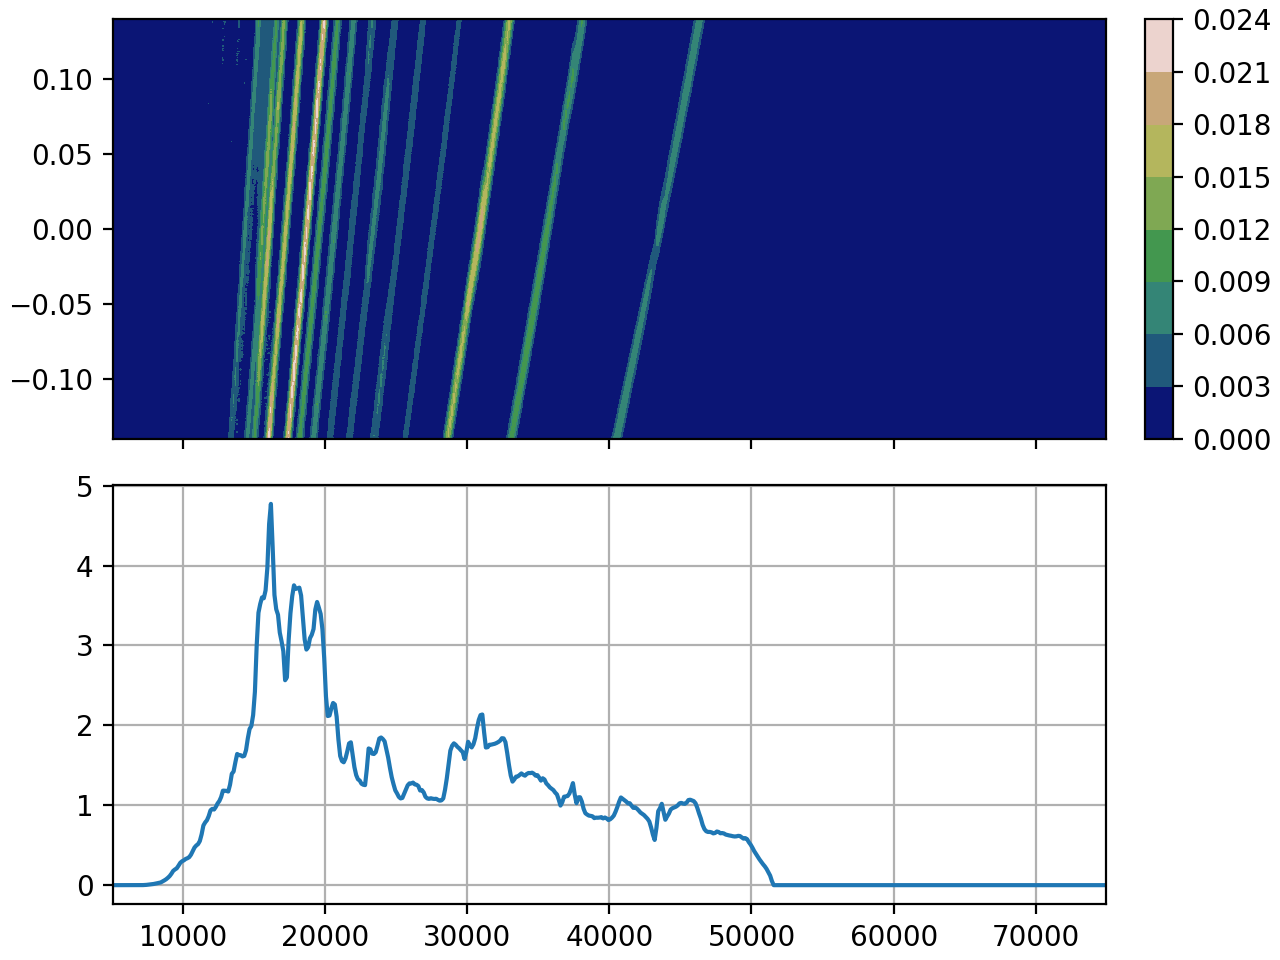

In [9]:
fig3, ax3 = plt.subplots(2, 1, constrained_layout=True, sharex=True)
cont3 = ax3[0].contourf(x, y, mcstas_stitched, cmap=colormap)
cbar3 = fig3.colorbar(cont3, ax=[ax3[0]], location='right')

ax3[1].plot(x, np.sum(mcstas_stitched, axis=0))
ax3[1].grid()

<IPython.core.display.Javascript object>


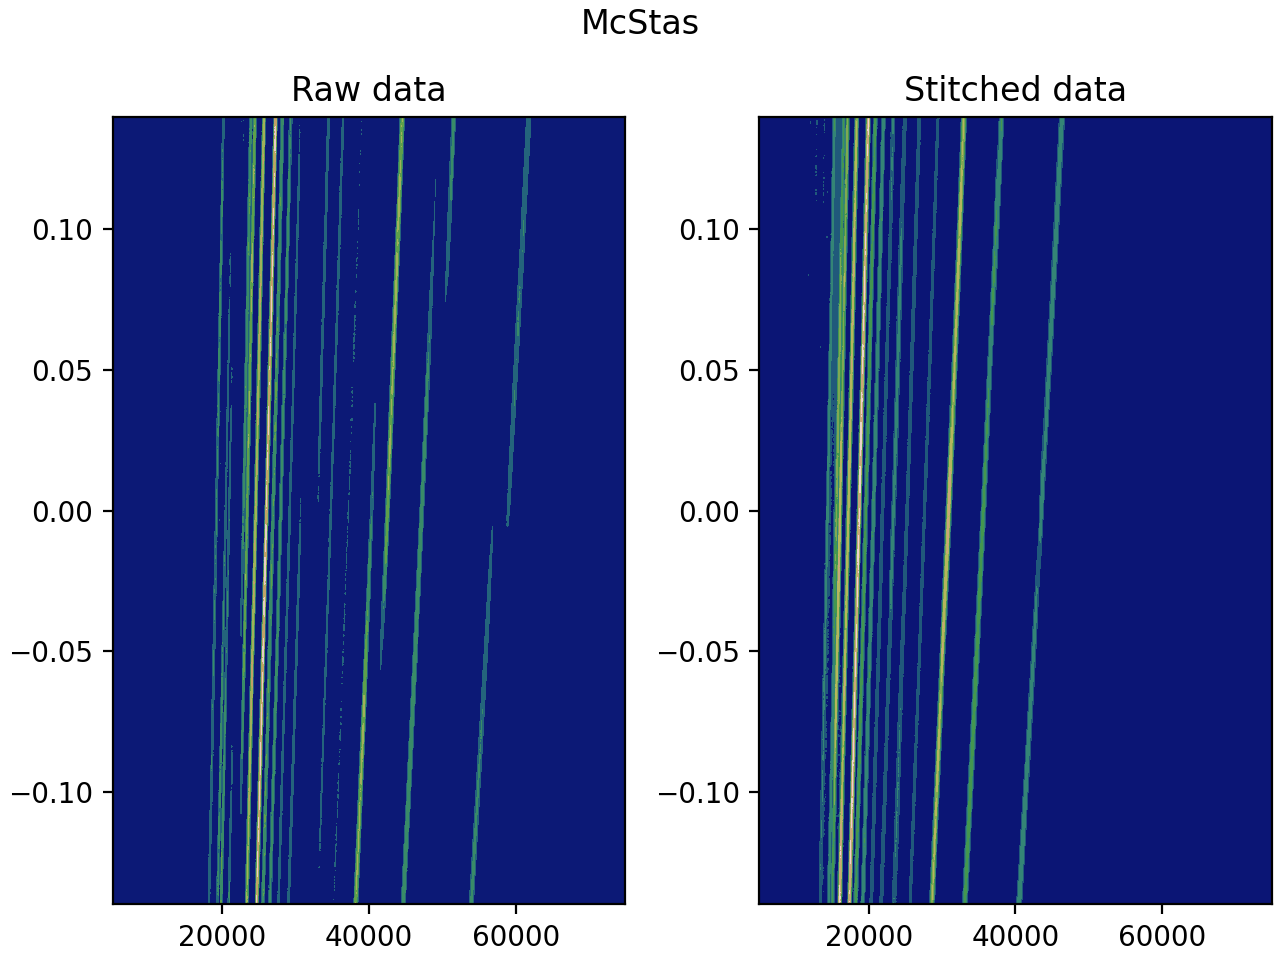

In [10]:
fig4, ax4 = plt.subplots(1, 2, constrained_layout=True)
fig4.suptitle('McStas')
ax4[0].contourf(x, y, data2d_mcstas, cmap=colormap)
ax4[0].set_title('Raw data')

ax4[1].set_title('Stitched data')
ax4[1].contourf(x, y, mcstas_stitched, cmap=colormap)

## ROOT file

In [11]:
# ROOT file
path_to_all_root_files = '/Users/celinedurniak/V20DiffractionData/DENEX'

assert os.path.isdir(path_to_all_root_files), \
    'The path to the folder which should contain ROOT files does not exist.'

ROOT_file_sp3 = "Spectrum03_DENEX006_1_18-02-05_0000.root"

path_to_root_file = os.path.join(path_to_all_root_files, ROOT_file_sp3)

# Some metadata related to TOF channel for ROOT file
tof_tick = 25e-3 # in microseconds (25 ns)

In [12]:
# open a ROOT file and extract only one 2D dataset specified in selected_dataset
# Note the vertical axis of 2D datasets is inverted

key_spectrum ='Spectrum03'
dir_with_data = 'Meas_3'
selected_dataset = 'H_TOF,X1-X2_User_2D2_dsp_after_run_3'

with uproot.open(path_to_root_file)[dir_with_data] as myFile:

    for key in myFile.keys():
        if 'BoardParam_run' in str(key):
            myObject = myFile[key]
            nb_xbins = myObject.numbins
            
            for i in range(nb_xbins):
                if 'TOF_Time_Channel_Width' in myObject.xlabels[i]:
                    TOF_Time_Channel_Width = myObject.values[i]
                elif 'TOF_Window_Delay_Register' in myObject.xlabels[i]:
                    TOF_Window_Delay_Register = myObject.values[i]
                    
                print(f"{myObject.xlabels[i]}: {myObject.values[i]}")

        # 2D contourplot
        if 'TH2' in str(myFile[key]) and selected_dataset in str(key):
            
            data2d_root_sp3 =  np.flip(myFile[key].values, 1).transpose()
            
            # extract info about x, y axis (min, max and number of bins) 
            x_min = myFile[key].xlow
            x_max = myFile[key].xhigh 
            bins_x = myFile[key].xnumbins 
            y_min = myFile[key].ylow 
            y_max = myFile[key].yhigh
            bins_y = myFile[key].ynumbins
            
            # create x- and y-axis
            xaxis = x_min + (x_max - x_min) / (bins_x - 1) * np.arange(bins_x)
            yaxis = y_min + (y_max - y_min) / (bins_y - 1) * np.arange(bins_y)

Latency_ns: 611.0
Resolution_ps: 120.0
TriggerWindow_ns: 590.0
ADC_Threshold_Level: 0.0
Delta_TDL_X_FPGA: 200.0
TDC_Trigger_Latency: 52.0
Test_Generator_Frequency_Coefficient: 40.0
TDL_X_FPGA: 4190.0
TOF_Number_of_Time_Channels: 1024.0
TOF_Time_Channel_Width: 2773.0
TOF_Window_Delay_Register: 250000.0
EnableTestGeneration: 0.0
TDL_Y_FPGA: 4235.0
Delta_TDL_Y_FPGA: 200.0
Standard_1D_DSP_size: 5000.0
fResolution_ps: 120.30075073242188
TOF_mode: 4.0
RAW_mode: 0.0
DSP_Buffer_Kwords: 500.0
Bits_Shifted_In_Pos: 0.0
TDL_X_DSP: 4235.0
Delta_TDL_X_DSP: 300.0
TDL_Y_DSP: 4275.0
Delta_TDL_Y_DSP: 300.0
X_Lenghth: 256.0
Y_Lenghth: 256.0
Hist2D0: 0.0
Hist2D1: 0.0
Hist1D: 0.0
LookUpTableFile: 0.0


In [13]:
# Convert TOF channels to microseconds:
# a TOF channel width is 2773 ticks and one tick is 25ns.
# Then also add a 6.25ms delay

xaxis = (xaxis * TOF_Time_Channel_Width + TOF_Window_Delay_Register) * tof_tick

<IPython.core.display.Javascript object>


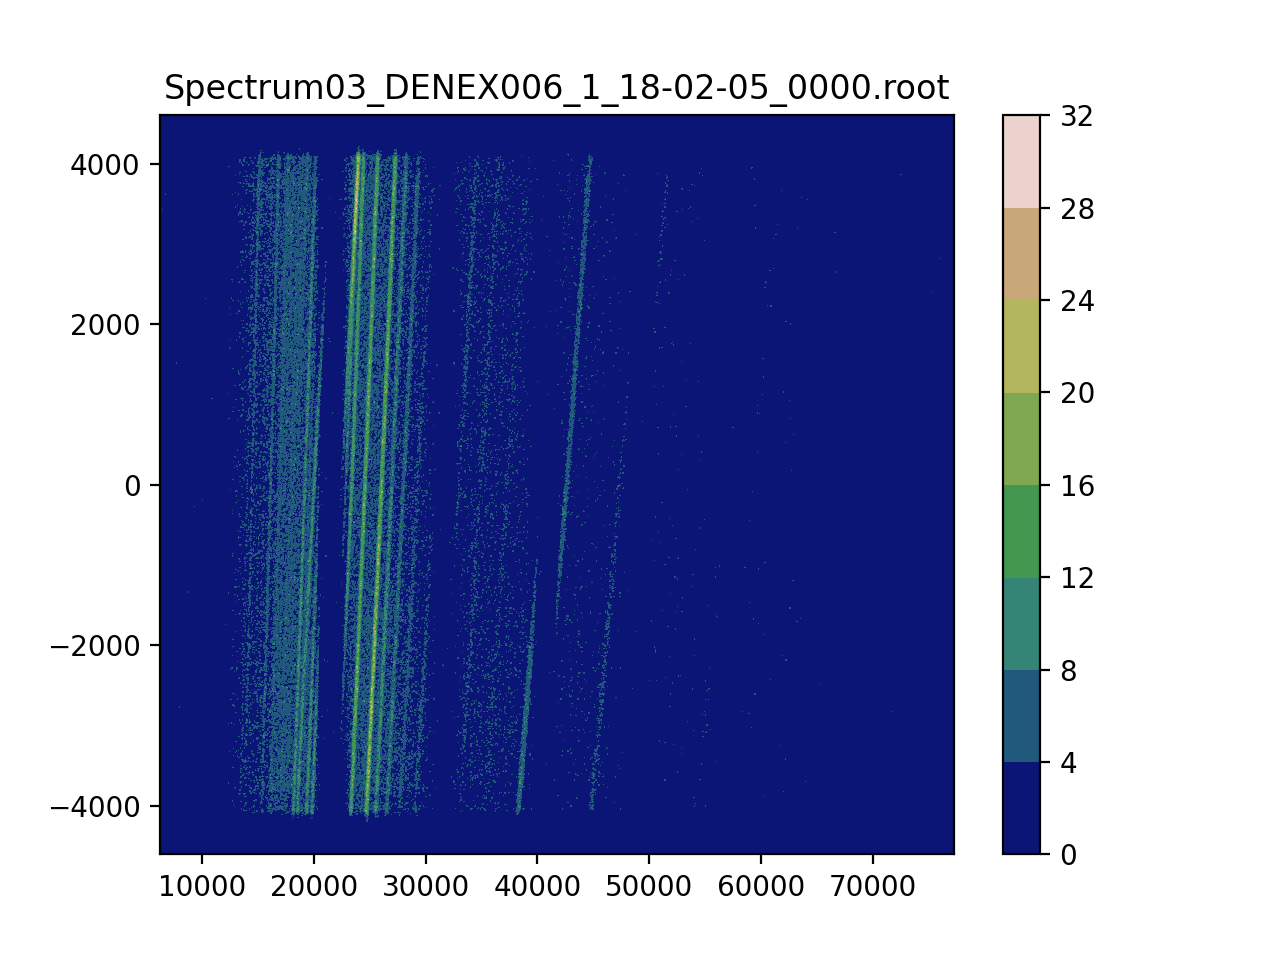

In [14]:
fig5, ax5 = plt.subplots()
cont5 = ax5.contourf(xaxis, yaxis, data2d_root_sp3, cmap=colormap)
ax5.set_title(ROOT_file_sp3)
cbar5 = fig5.colorbar(cont5)

<IPython.core.display.Javascript object>


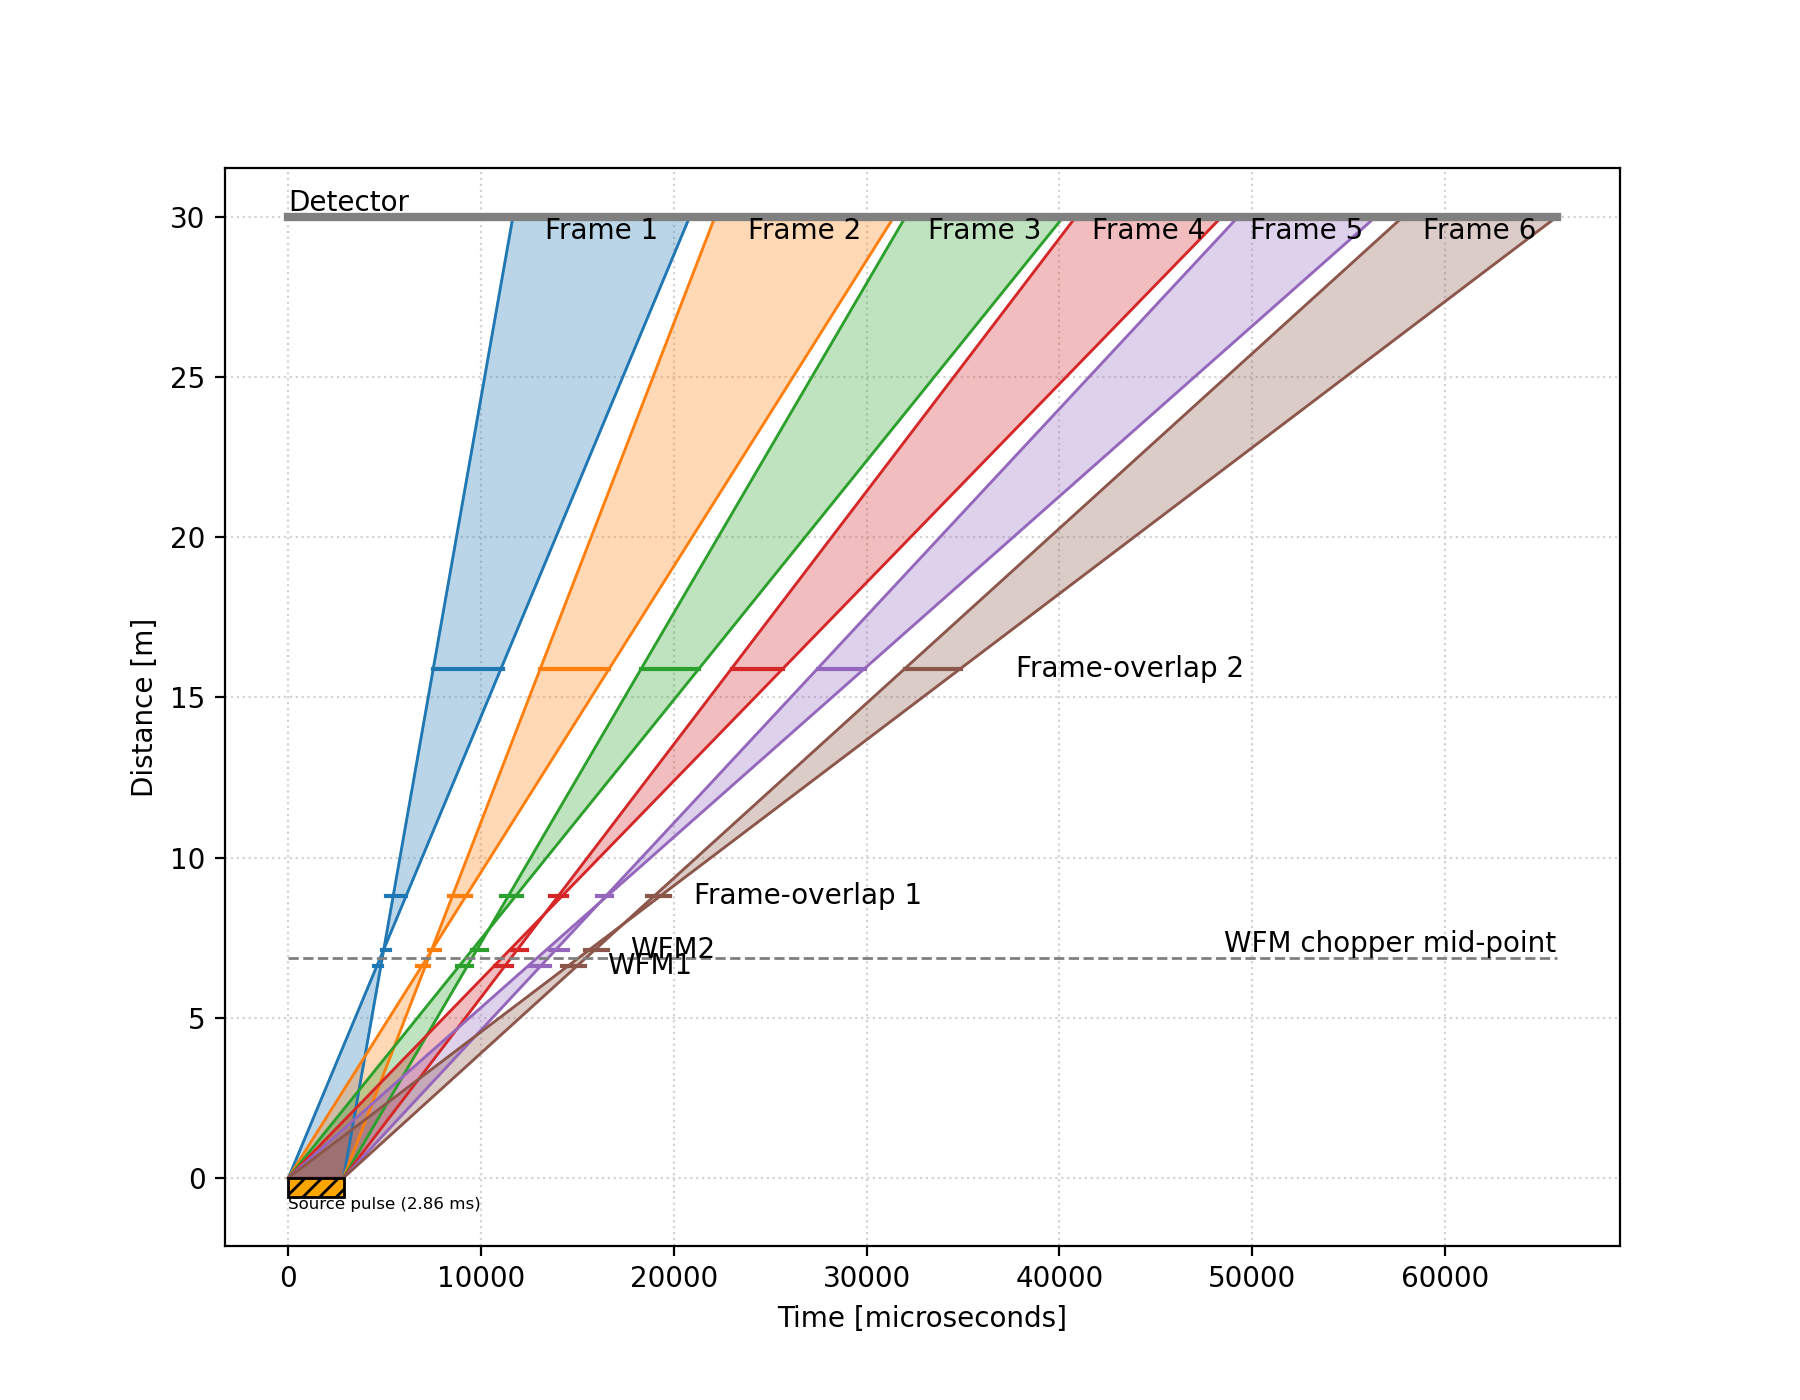

In [15]:
# Note I had to change the distance to the detector again from 30.5 -> 30.0
v20setup["info"]["detector_position"] = 30.0
# Get WFM frame parameters and generate TOF diagram
frame_params = wfmess.get_frame_parameters(instrument=v20setup, plot=True)

<IPython.core.display.Javascript object>


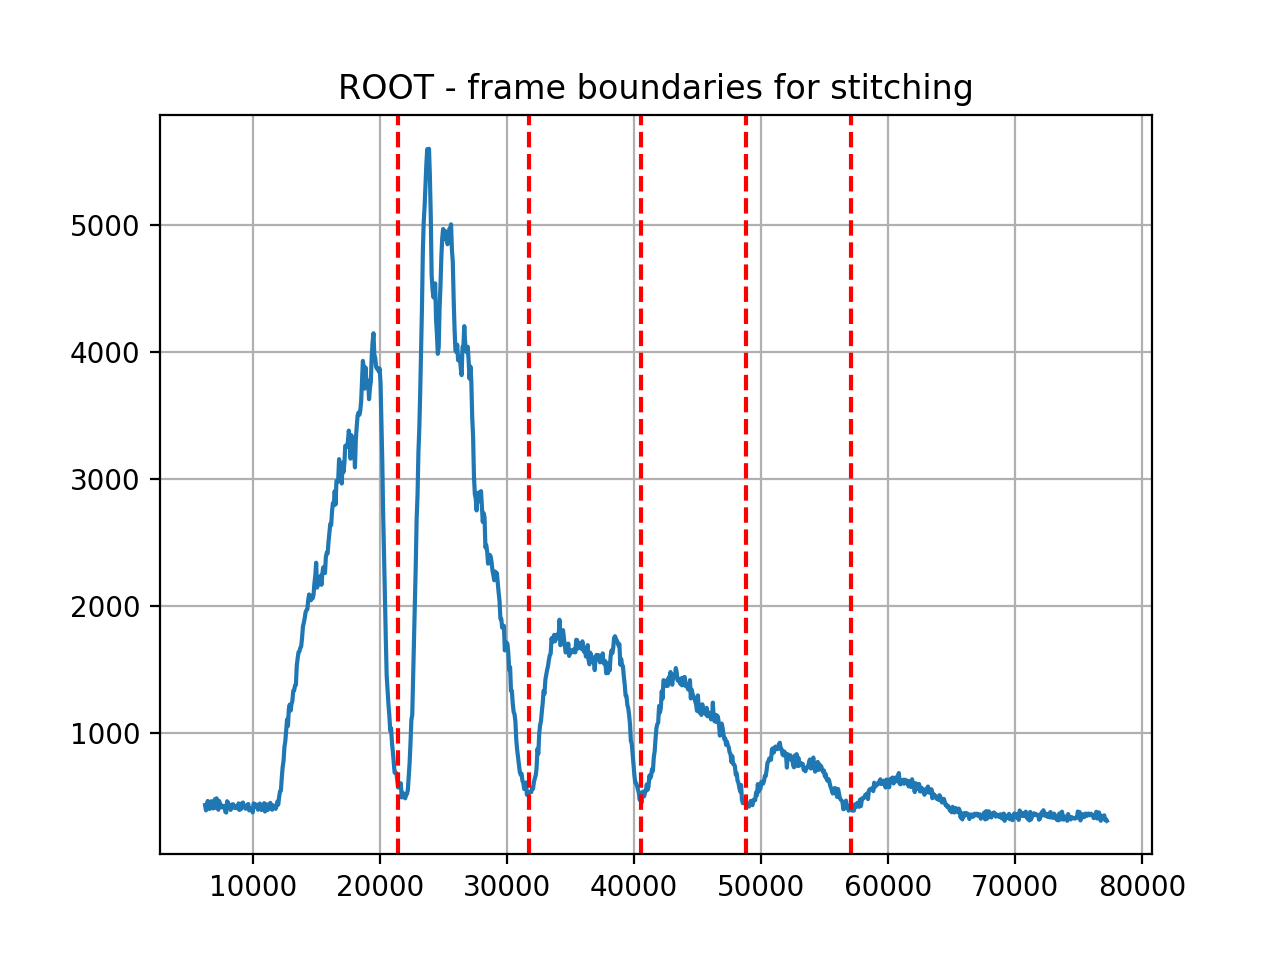

In [16]:
# Plot frame locations onto raw data
fig6, ax6 = plt.subplots()
ax6.plot(xaxis, np.sum(data2d_root_sp3, axis=0))
ax6.grid()
ax6.set_title('ROOT - frame boundaries for stitching')
for g in frame_params["gaps"]:
    ax6.axvline(x=g, linestyle='--', color='r')

In [17]:
# Stitch the 2d histogram
root_stitched_sp3 = wfmess.stitch(x=xaxis, y=data2d_root_sp3, frame_params=frame_params)

<IPython.core.display.Javascript object>


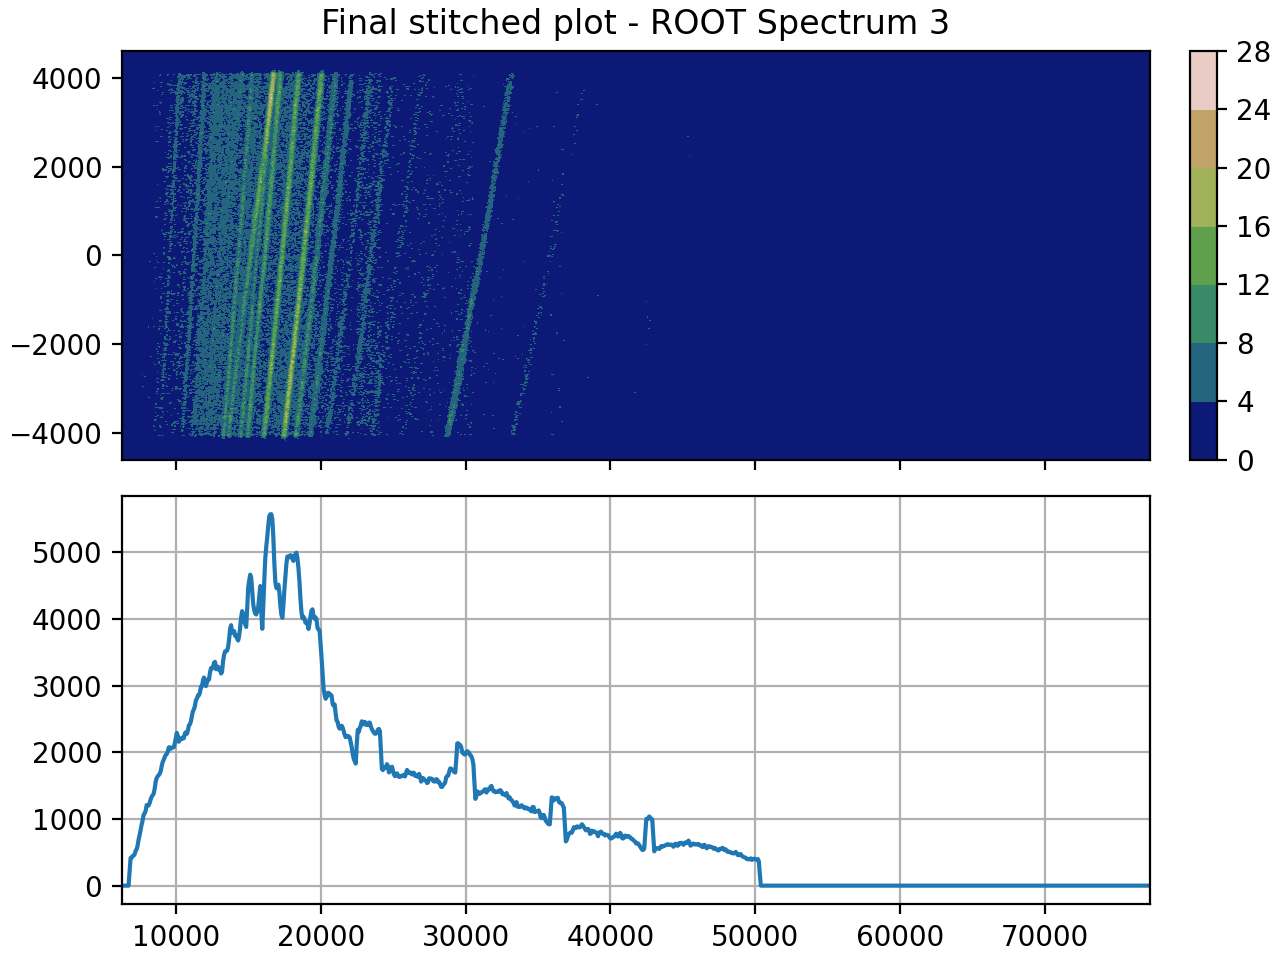

In [18]:
fig7, ax7 = plt.subplots(2, 1, constrained_layout=True, sharex=True)
ax7[0].set_title('Final stitched plot - ROOT Spectrum 3')
cont7 = ax7[0].contourf(xaxis, yaxis, root_stitched_sp3, cmap=colormap)
fig7.colorbar(cont7, ax=[ax7[0]], location='right')

ax7[1].plot(xaxis, np.sum(root_stitched_sp3, axis=0))
ax7[1].grid()

<IPython.core.display.Javascript object>


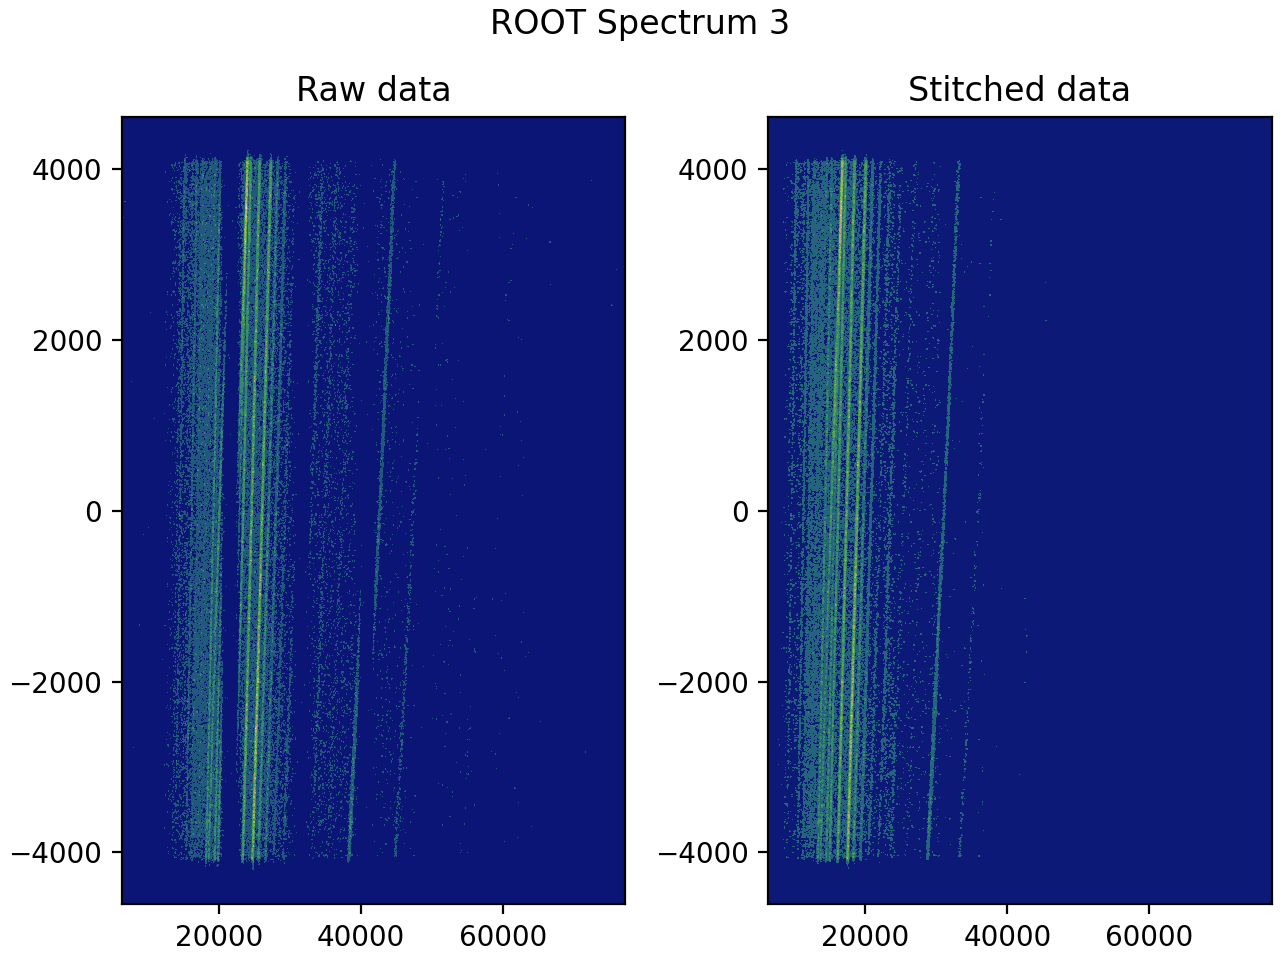

In [20]:
fig8, ax8 = plt.subplots(1, 2, constrained_layout=True)
fig8.suptitle('ROOT Spectrum 3')
ax8[0].contourf(xaxis, yaxis, data2d_root_sp3, cmap=colormap)
ax8[0].set_title('Raw data')

ax8[1].set_title('Stitched data')
ax8[1].contourf(xaxis, yaxis, root_stitched_sp3, cmap=colormap);

## Spectrum 11

In [21]:
# open a ROOT file and extract only one 2D dataset specified in selected_dataset
# Note the vertical axis of 2D datasets is inverted

ROOT_file_sp11 = "Spectrum11_DENEX006_1_18-02-09_0001.root"
path_to_root_file = os.path.join(path_to_all_root_files, ROOT_file_sp11)
key_spectrum ='Spectrum11'
dir_with_data = 'Meas_1'
selected_dataset = 'H_TOF,X1-X2_User_2D4_dsp_after_run_1'

with uproot.open(path_to_root_file)[dir_with_data] as myFile:

    for key in myFile.keys():
        if 'BoardParam_run' in str(key):
            myObject = myFile[key]
            nb_xbins = myObject.numbins
            
            for i in range(nb_xbins):
                if 'TOF_Time_Channel_Width' in myObject.xlabels[i]:
                    TOF_Time_Channel_Width = myObject.values[i]
                elif 'TOF_Window_Delay_Register' in myObject.xlabels[i]:
                    TOF_Window_Delay_Register = myObject.values[i]
                    
                #print(f"{myObject.xlabels[i]}: {myObject.values[i]}")

        # 2D contourplot
        if 'TH2' in str(myFile[key]) and selected_dataset in str(key):
            
            data2d_root_sp11 =  np.flip(myFile[key].values, 1).transpose()
            
            # extract info about x, y axis (min, max and number of bins) 
            x_min = myFile[key].xlow
            x_max = myFile[key].xhigh 
            bins_x = myFile[key].xnumbins 
            y_min = myFile[key].ylow 
            y_max = myFile[key].yhigh
            bins_y = myFile[key].ynumbins
            
            # create x- and y-axis
            xaxis = x_min + (x_max - x_min) / (bins_x - 1) * np.arange(bins_x)
            yaxis = y_min + (y_max - y_min) / (bins_y - 1) * np.arange(bins_y)

In [22]:
# Convert TOF channels to microseconds:
# a TOF channel width is 2773 ticks and one tick is 25ns.
# Then also add a 6.25ms delay
xaxis = (xaxis * TOF_Time_Channel_Width + TOF_Window_Delay_Register) * tof_tick

<IPython.core.display.Javascript object>


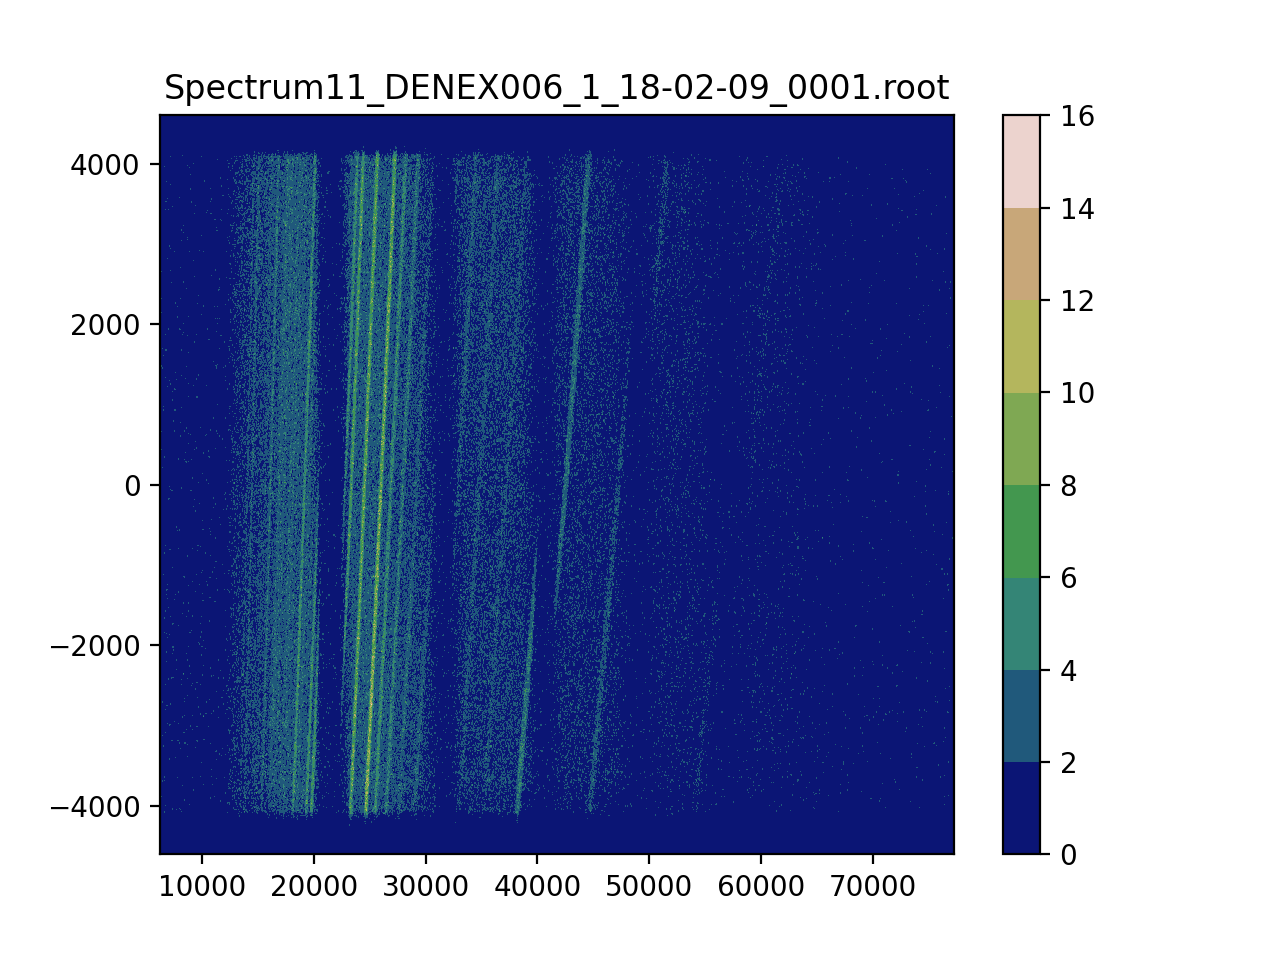

In [23]:
fig9, ax9 = plt.subplots()
cont9 = ax9.contourf(xaxis, yaxis, data2d_root_sp11, cmap=colormap)
ax9.set_title(ROOT_file_sp11)
cbar9 = fig9.colorbar(cont9)

<IPython.core.display.Javascript object>


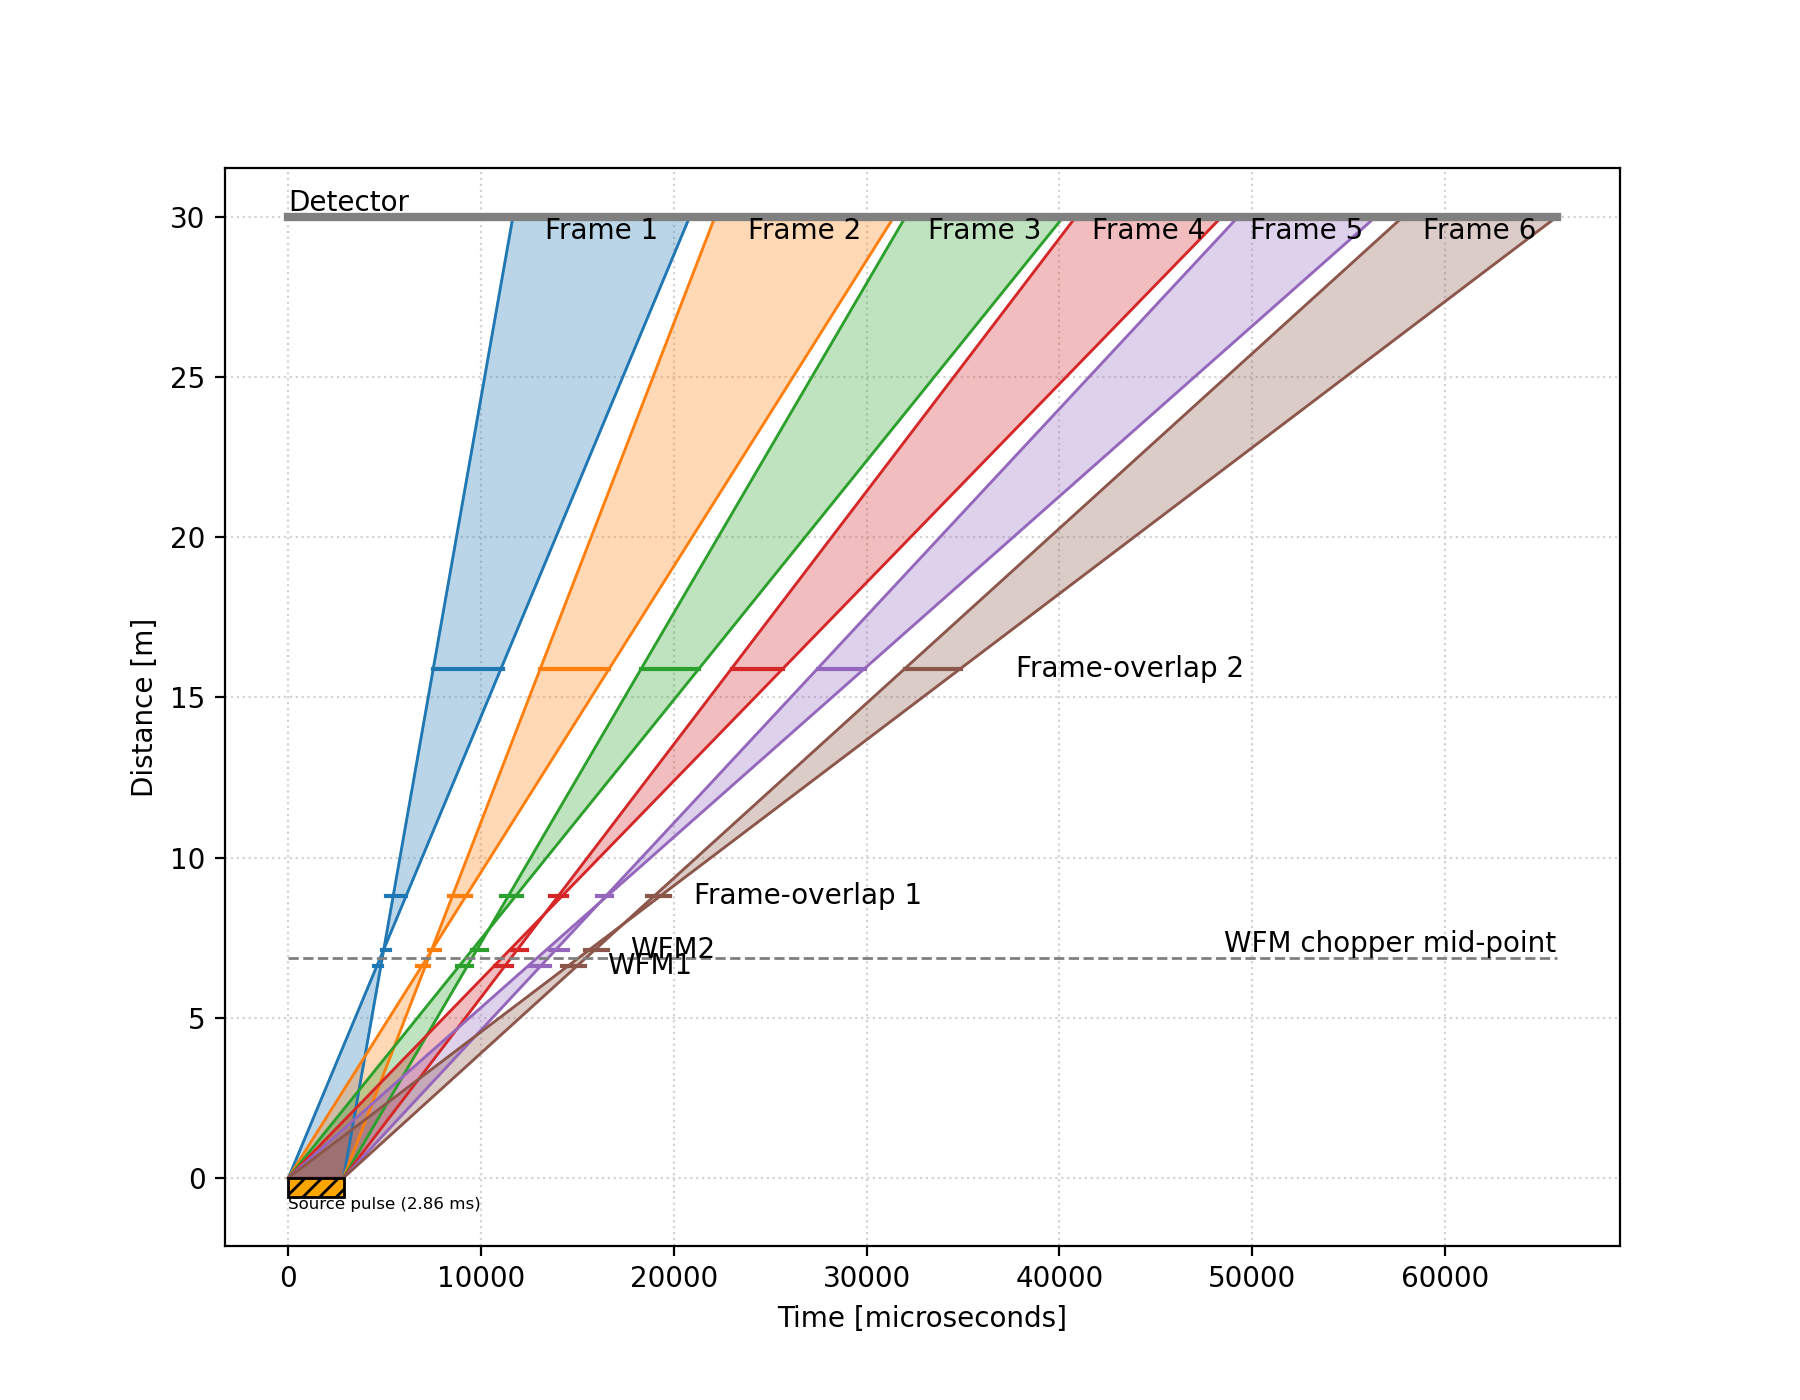

In [24]:
# Note I had to change the distance to the detector again from 30.5 -> 30.0
v20setup["info"]["detector_position"] = 30.0
# Get WFM frame parameters and generate TOF diagram
frame_params = wfmess.get_frame_parameters(instrument=v20setup, plot=True)

<IPython.core.display.Javascript object>


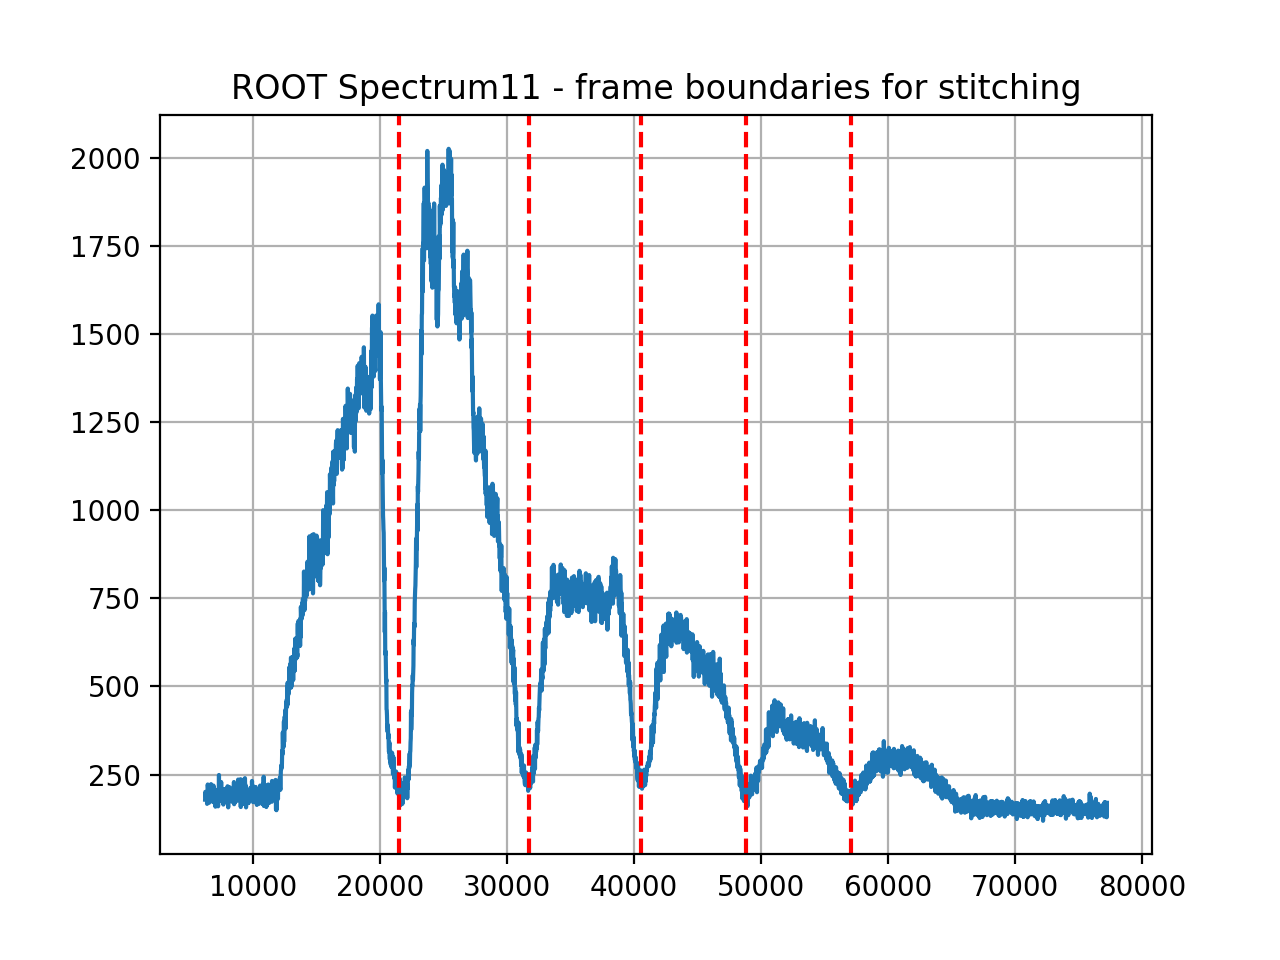

In [25]:
# Plot frame locations onto raw data
fig10, ax10 = plt.subplots()
ax10.plot(xaxis, np.sum(data2d_root_sp11, axis=0))
ax10.grid()
ax10.set_title('ROOT Spectrum11 - frame boundaries for stitching')
for g in frame_params["gaps"]:
    ax10.axvline(x=g, linestyle='--', color='r')

In [26]:
# Stitch the 2d histogram
root_stitched_sp11 = wfmess.stitch(x=xaxis, y=data2d_root_sp11, frame_params=frame_params)

<IPython.core.display.Javascript object>


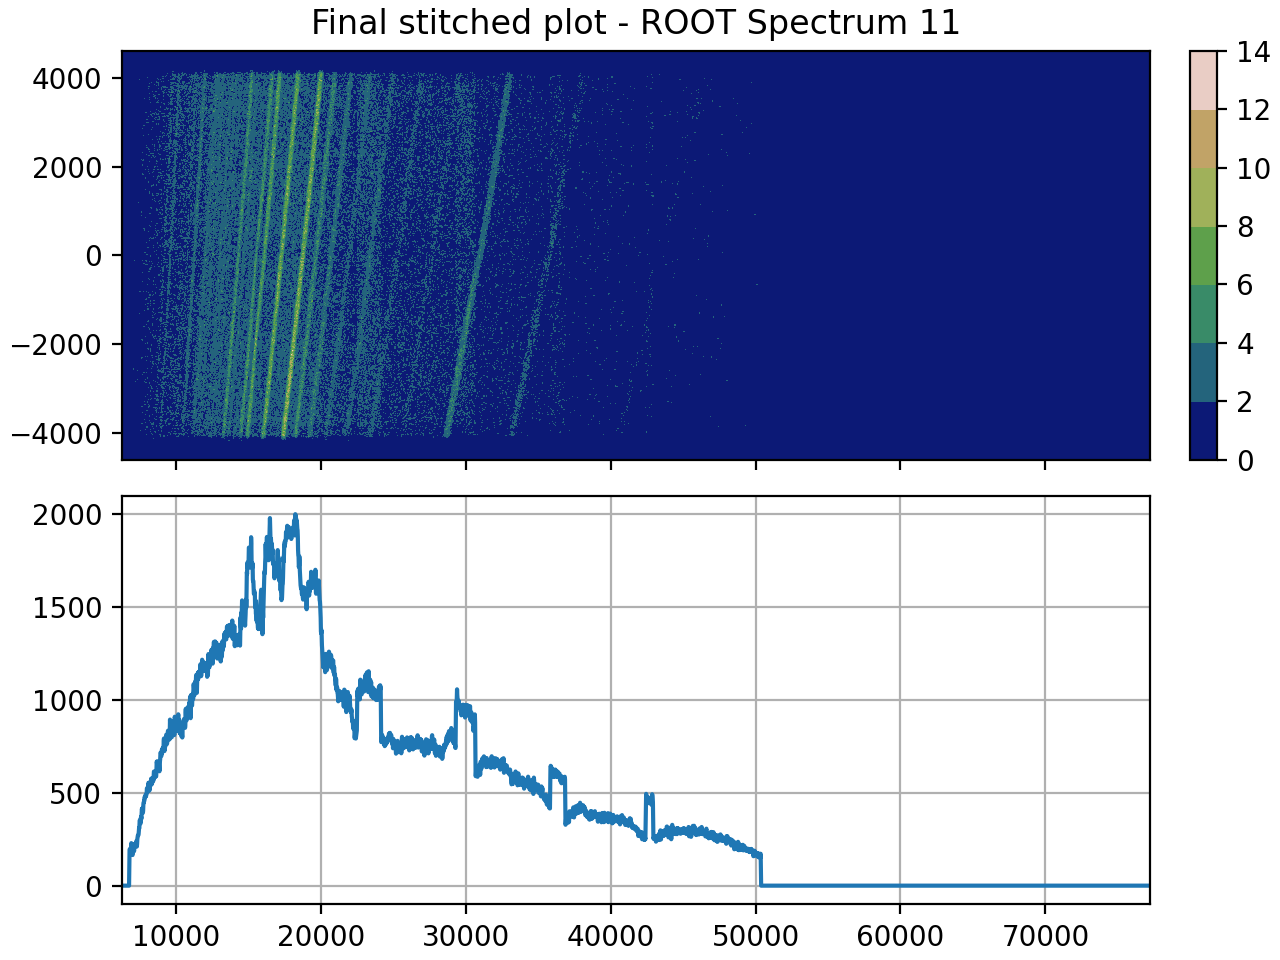

In [27]:
fig11, ax11 = plt.subplots(2, 1, constrained_layout=True, sharex=True)
ax11[0].set_title('Final stitched plot - ROOT Spectrum 11')
cont11 = ax11[0].contourf(xaxis, yaxis, root_stitched_sp11, cmap=colormap)
fig11.colorbar(cont11, ax=[ax11[0]], location='right')
ax11[1].plot(xaxis, np.sum(root_stitched_sp11, axis=0))
ax11[1].grid()

## Spectrum 12

In [28]:
# open a ROOT file and extract only one 2D dataset specified in selected_dataset
# Note the vertical axis of 2D datasets is inverted

ROOT_file_sp12 = 'Spectrum12_DENEX006_1_18-02-10_0000.root'
path_to_root_file = os.path.join(path_to_all_root_files, ROOT_file_sp12)
key_spectrum ='Spectrum12'
dir_with_data = 'Meas_1'
selected_dataset = 'H_TOF,X1-X2_User_2D4_dsp_after_run_1'

with uproot.open(path_to_root_file)[dir_with_data] as myFile:

    for key in myFile.keys():
        if 'BoardParam_run' in str(key):
            myObject = myFile[key]
            nb_xbins = myObject.numbins
            
            for i in range(nb_xbins):
                if 'TOF_Time_Channel_Width' in myObject.xlabels[i]:
                    TOF_Time_Channel_Width = myObject.values[i]
                elif 'TOF_Window_Delay_Register' in myObject.xlabels[i]:
                    TOF_Window_Delay_Register = myObject.values[i]
                    
                print(f"{myObject.xlabels[i]}: {myObject.values[i]}")

        # 2D contourplot
        if 'TH2' in str(myFile[key]) and selected_dataset in str(key):
            
            data2d_root_sp12 =  np.flip(myFile[key].values, 1).transpose()
            
            # extract info about x, y axis (min, max and number of bins) 
            x_min = myFile[key].xlow
            x_max = myFile[key].xhigh 
            bins_x = myFile[key].xnumbins 
            y_min = myFile[key].ylow 
            y_max = myFile[key].yhigh
            bins_y = myFile[key].ynumbins
            
            # create x- and y-axis
            xaxis = x_min + (x_max - x_min) / (bins_x - 1) * np.arange(bins_x)
            yaxis = y_min + (y_max - y_min) / (bins_y - 1) * np.arange(bins_y)

Latency_ns: 611.0
Resolution_ps: 120.0
TriggerWindow_ns: 590.0
ADC_Threshold_Level: 0.0
Delta_TDL_X_FPGA: 200.0
TDC_Trigger_Latency: 52.0
Test_Generator_Frequency_Coefficient: 40.0
TDL_X_FPGA: 4190.0
TOF_Number_of_Time_Channels: 4096.0
TOF_Time_Channel_Width: 693.0
TOF_Window_Delay_Register: 250000.0
EnableTestGeneration: 0.0
TDL_Y_FPGA: 4235.0
Delta_TDL_Y_FPGA: 200.0
Standard_1D_DSP_size: 5000.0
fResolution_ps: 120.30075073242188
TOF_mode: 4.0
RAW_mode: 0.0
DSP_Buffer_Kwords: 500.0
Bits_Shifted_In_Pos: 0.0
TDL_X_DSP: 4235.0
Delta_TDL_X_DSP: 300.0
TDL_Y_DSP: 4275.0
Delta_TDL_Y_DSP: 300.0
X_Lenghth: 256.0
Y_Lenghth: 256.0
Hist2D0: 0.0
Hist2D1: 0.0
Hist1D: 0.0
LookUpTableFile: 0.0


In [29]:
# Convert TOF channels to microseconds:
# a TOF channel width is 2773 ticks and one tick is 25ns.
# Then also add a 6.25ms delay
xaxis = (xaxis * TOF_Time_Channel_Width + TOF_Window_Delay_Register) * tof_tick

<IPython.core.display.Javascript object>


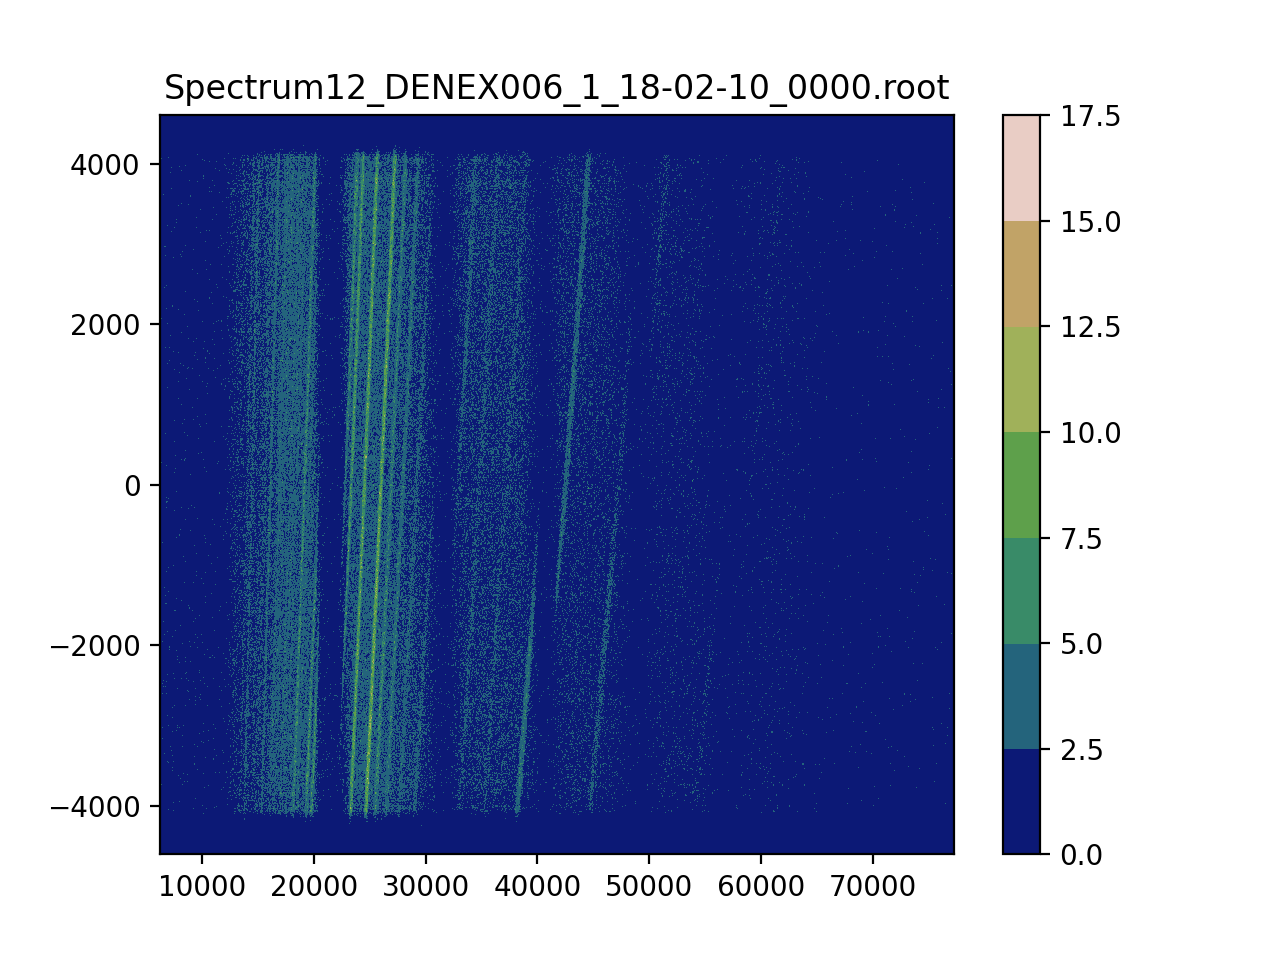

In [30]:
fig12, ax12 = plt.subplots()
cont12 = ax12.contourf(xaxis, yaxis, data2d_root_sp12, cmap=colormap)
ax12.set_title(ROOT_file_sp12)
cbar12 = fig12.colorbar(cont12)

<IPython.core.display.Javascript object>


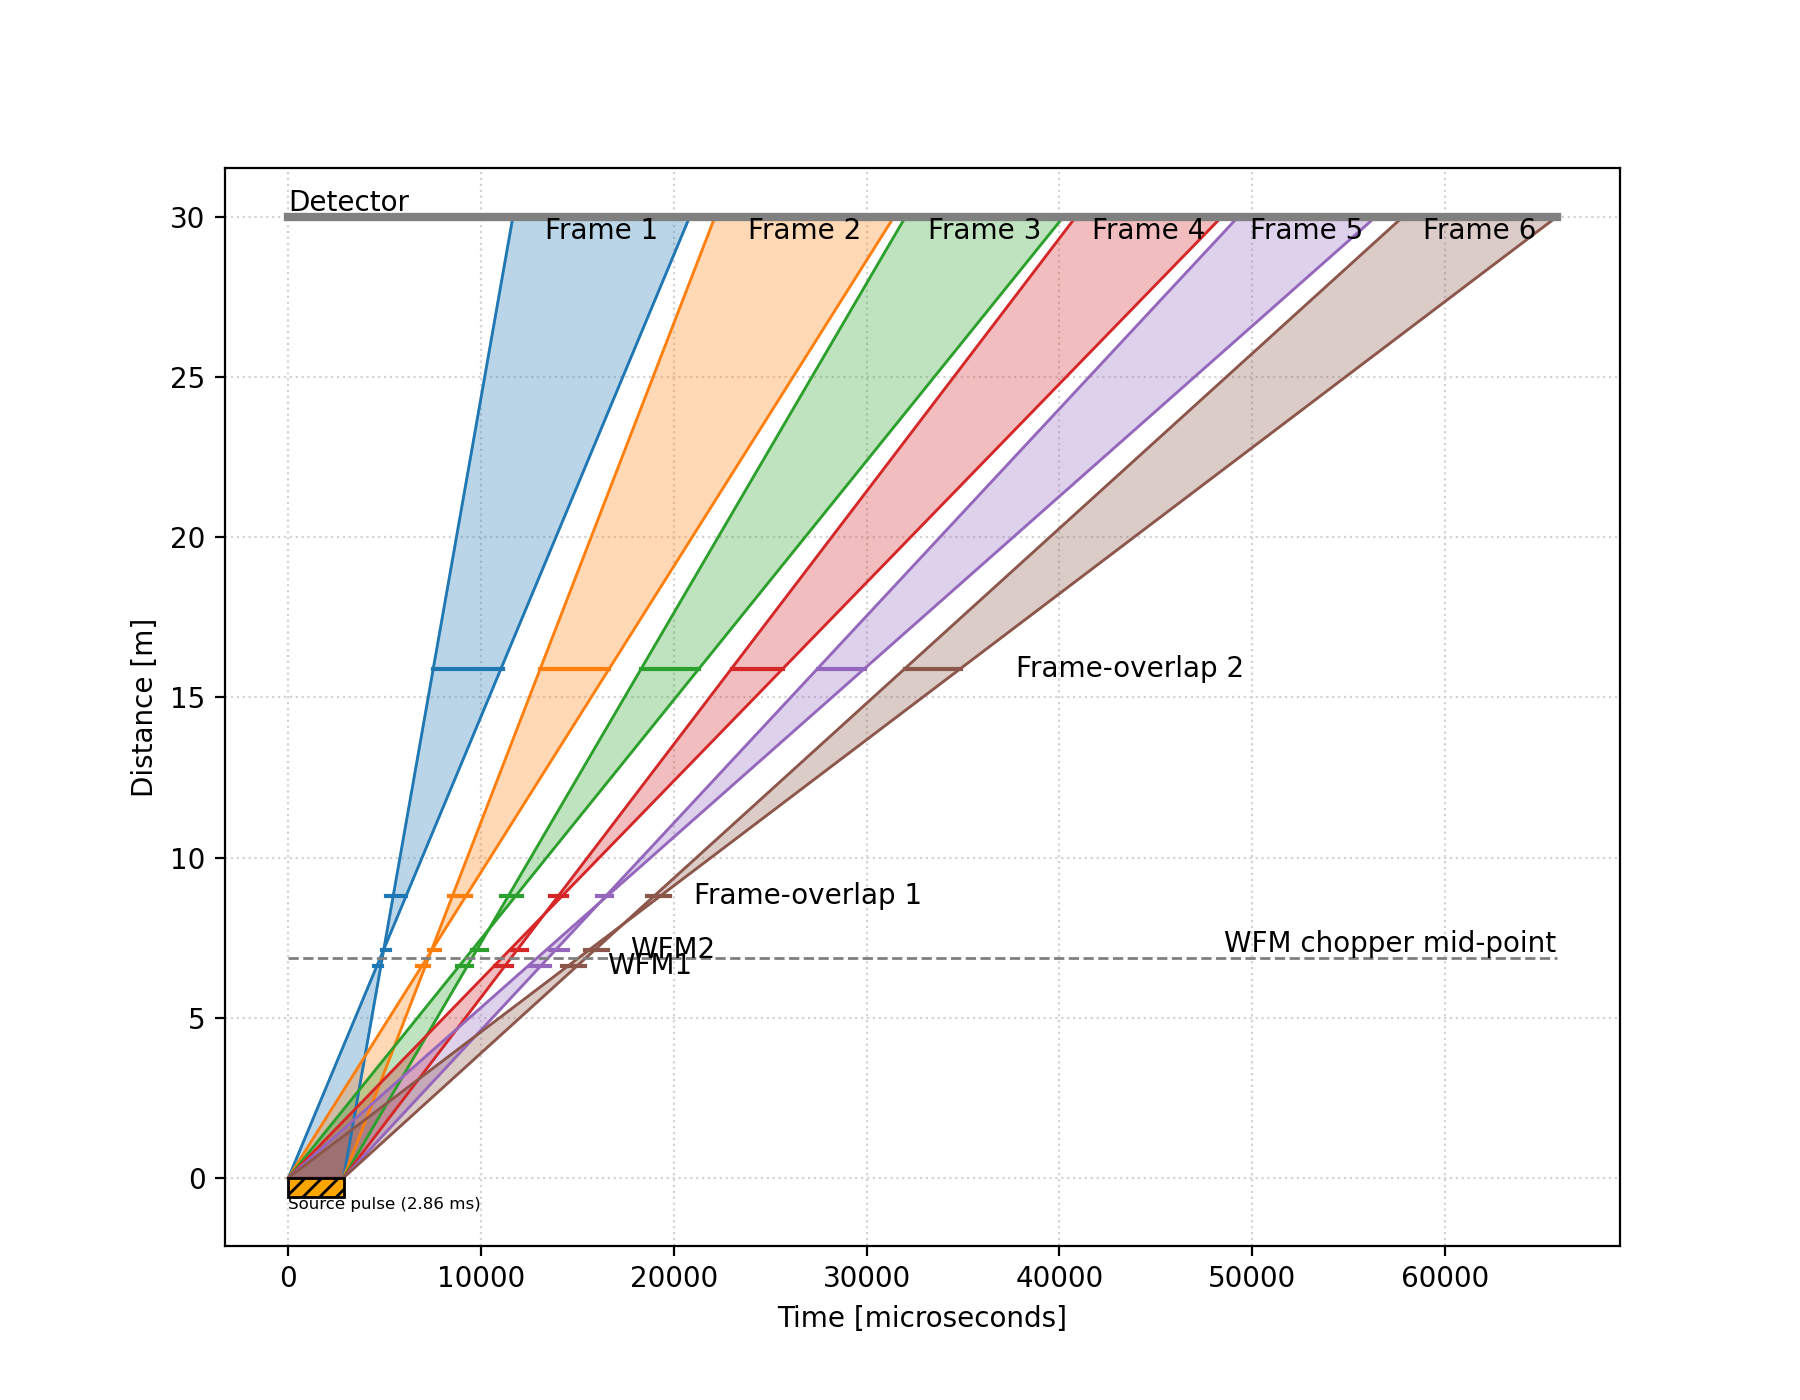

In [31]:
# Note I had to change the distance to the detector again from 30.5 -> 30.0
v20setup["info"]["detector_position"] = 30.0
# Get WFM frame parameters and generate TOF diagram
frame_params = wfmess.get_frame_parameters(instrument=v20setup, plot=True)

<IPython.core.display.Javascript object>


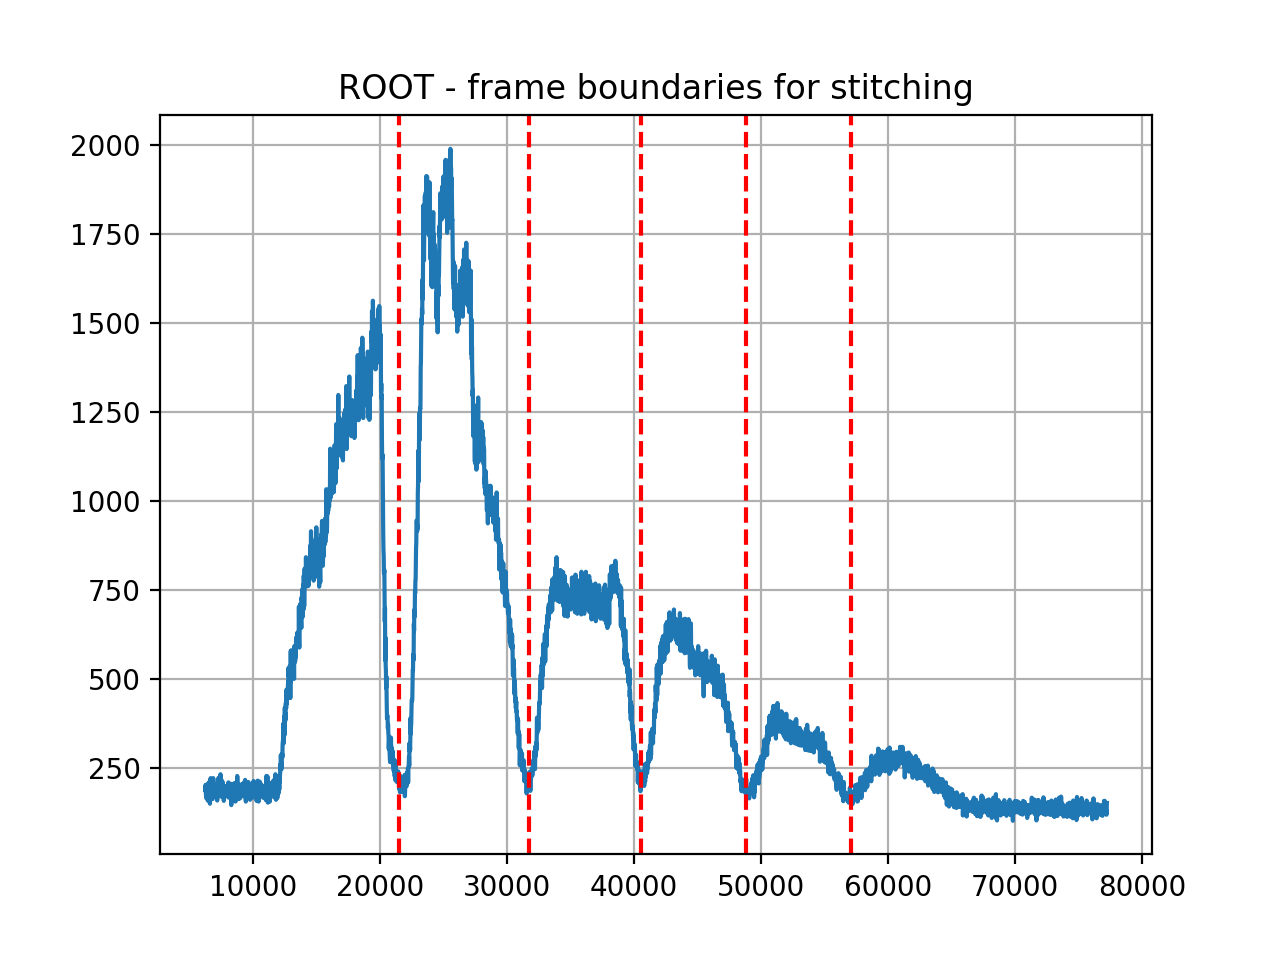

In [32]:
# Plot frame locations onto raw data
fig13, ax13 = plt.subplots()
ax13.plot(xaxis, np.sum(data2d_root_sp12, axis=0))
ax13.grid()
ax13.set_title('ROOT - frame boundaries for stitching')
for gap in frame_params["gaps"]:
    ax13.axvline(x=gap, linestyle='--', color='r')

In [33]:
# Stitch the 2d histogram
root_stitched_sp12 = wfmess.stitch(x=xaxis, 
                                   y=data2d_root_sp12, 
                                   frame_params=frame_params)

<IPython.core.display.Javascript object>


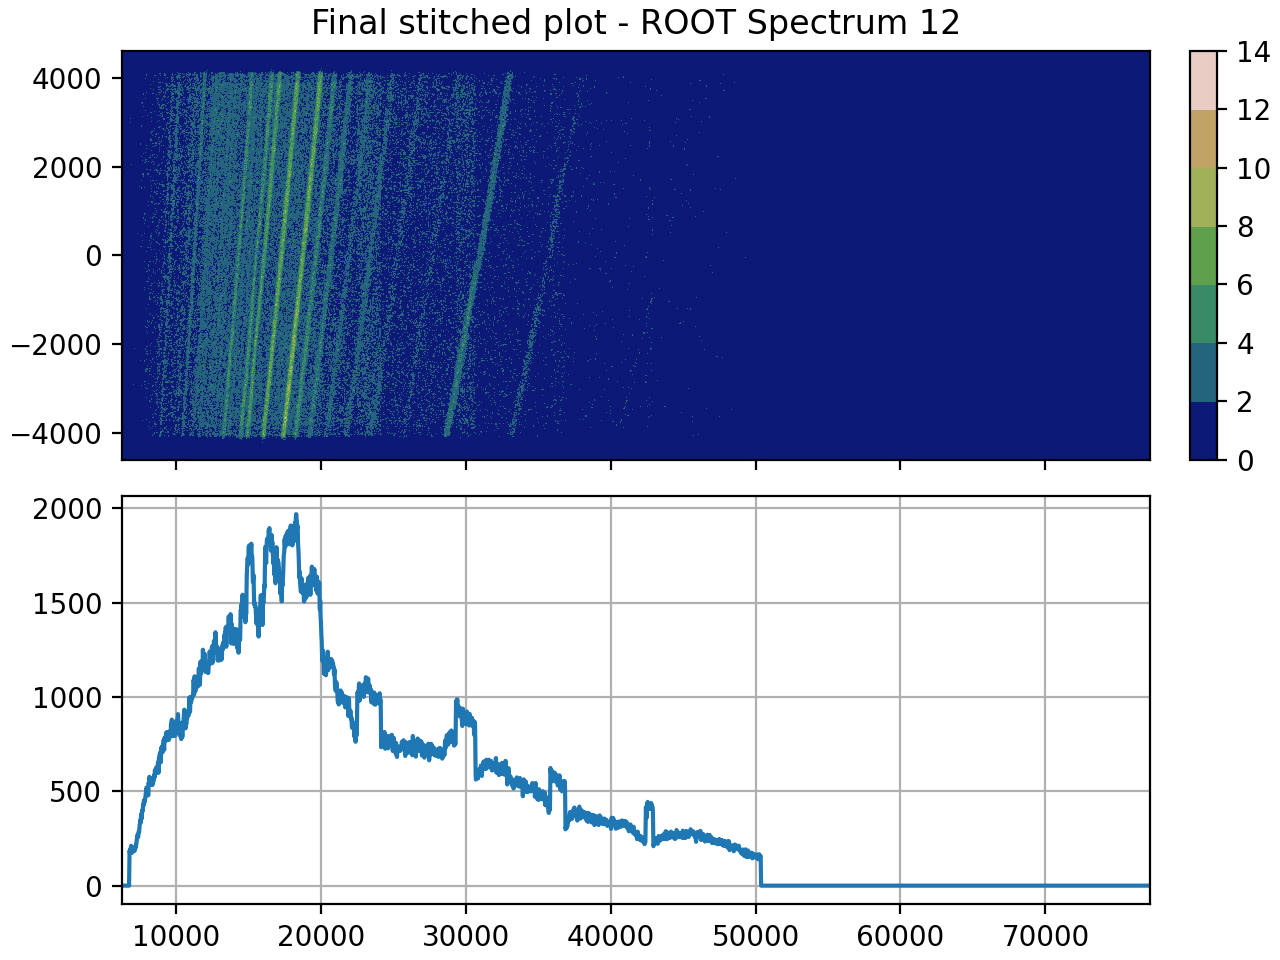

In [34]:
fig14, ax14 = plt.subplots(2, 1, constrained_layout=True, sharex=True)
ax14[0].set_title('Final stitched plot - ROOT Spectrum 12')
cont14 = ax14[0].contourf(xaxis, yaxis, root_stitched_sp12, cmap=colormap)
fig14.colorbar(cont14, ax=[ax14[0]], location='right')
ax14[1].plot(xaxis, np.sum(root_stitched_sp12, axis=0))
ax14[1].grid()

<IPython.core.display.Javascript object>


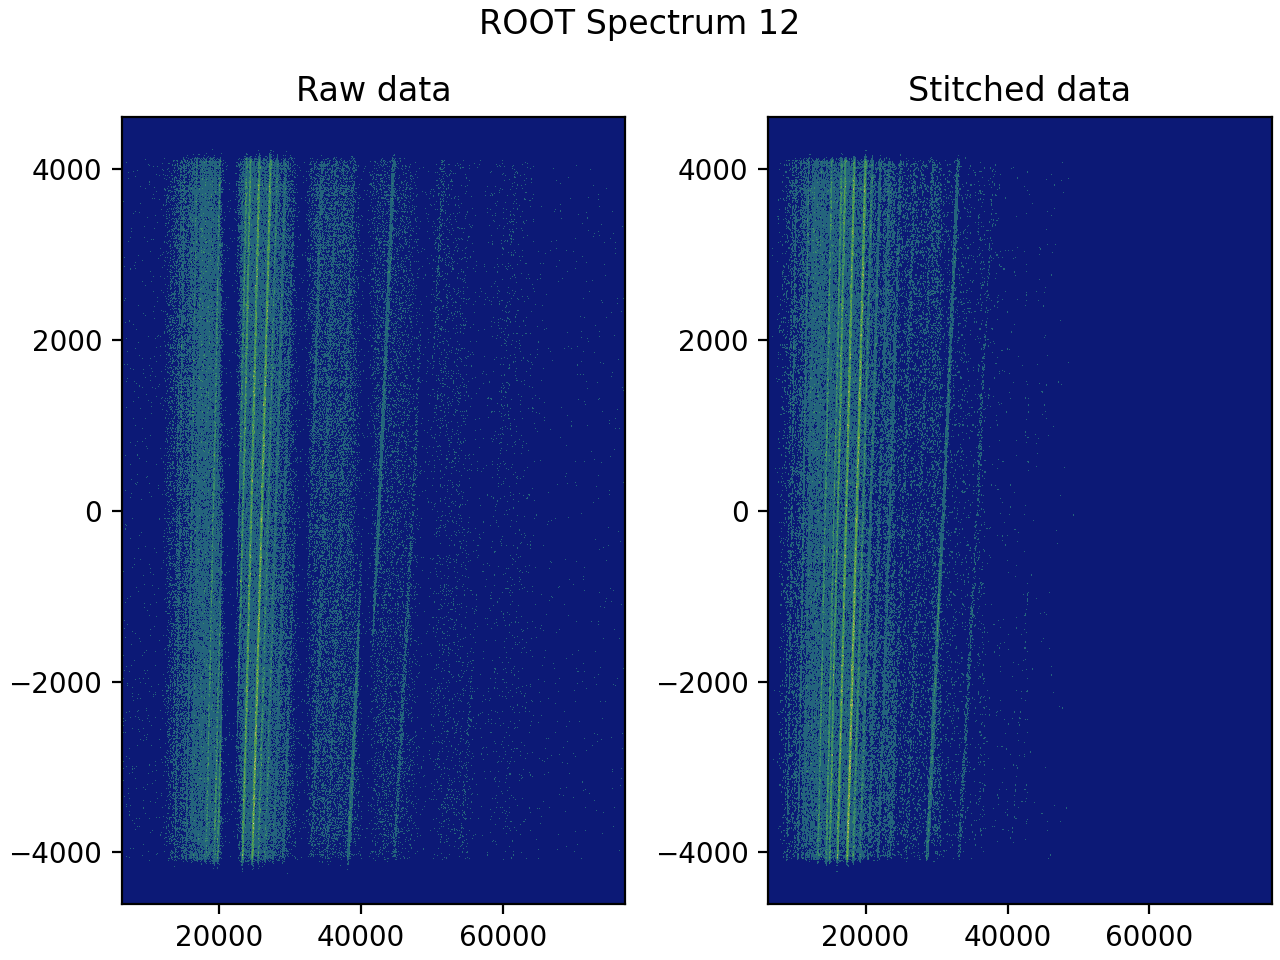

In [35]:
fig15, ax15 = plt.subplots(1, 2, constrained_layout=True)
fig15.suptitle('ROOT Spectrum 12')
ax15[0].contourf(xaxis, yaxis, data2d_root_sp12, cmap=colormap)
ax15[0].set_title('Raw data')

ax15[1].set_title('Stitched data')
ax15[1].contourf(xaxis, yaxis, root_stitched_sp12, cmap=colormap);